<a href="https://colab.research.google.com/github/Bukreevaa/IB_ML_2023/blob/Homework_2/ML_homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return np.sin(2*w)

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    if x0 == None:
      w0 = np.random.random(2)
    else:
      w0 = x0


    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr*grad_f(curr_w)

    return np.vstack(history)

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

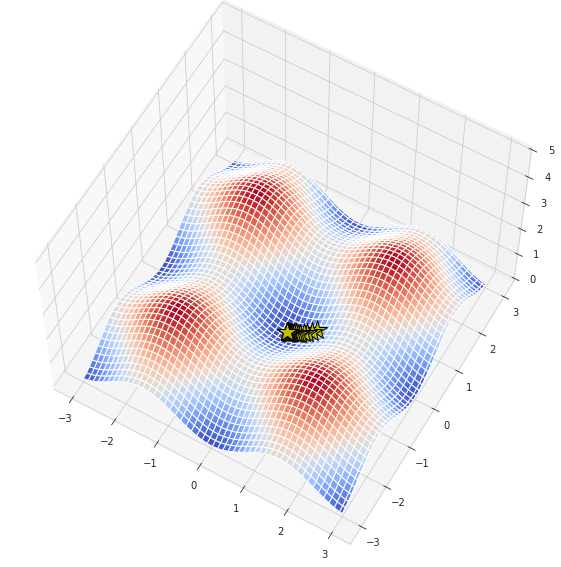

In [8]:
steps = gradient_desc_vis(f, grad_f)

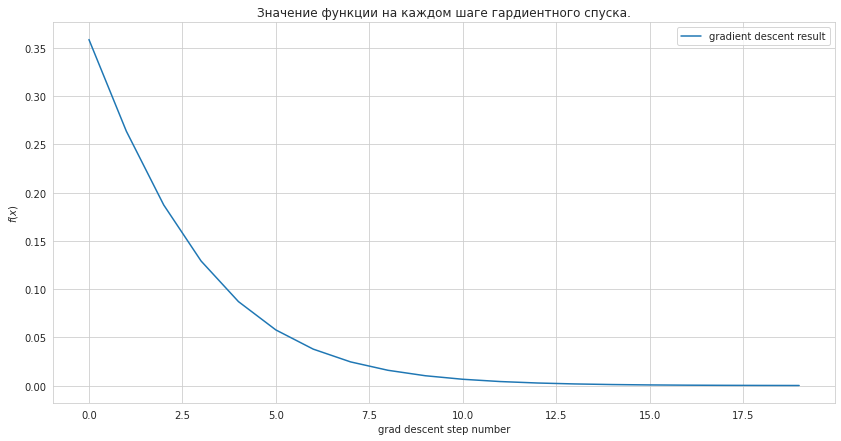

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return sum((y_true - y_pred) ** 2)/len(y_pred)

In [11]:
def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return 2/len(y_pred) * X.T.dot(y_pred - y_true) 

In [12]:
class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

In [13]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

In [14]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

In [15]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return X_test @ self.W
    
    
    def __repr__(self):
        return "My custom linear regression"

In [16]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

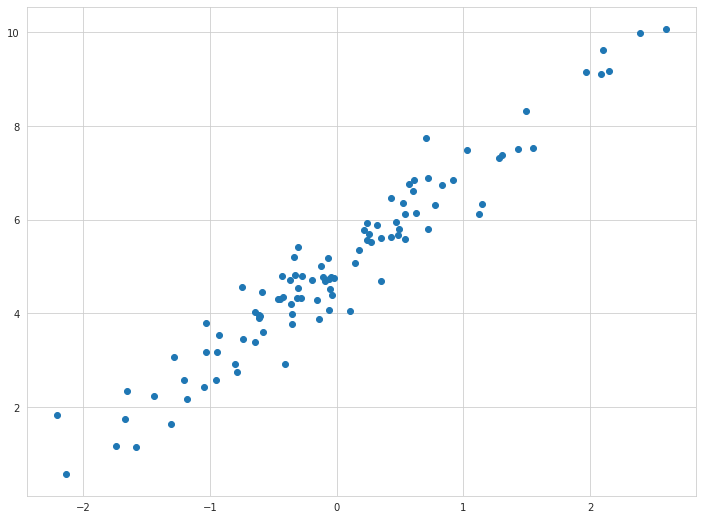

In [17]:
plt.scatter(X, y);

In [18]:
custom_lin_reg = CustomLinearRegression()

In [19]:
custom_lin_reg.fit(X, y)

My custom linear regression

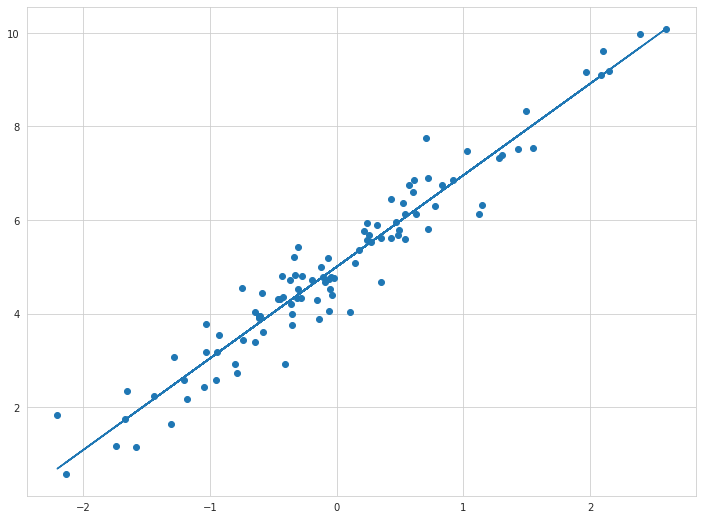

In [20]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

In [80]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
print(f"Train size = {y_train.shape}")
print(f"Test size = {y_test.shape}")

Train size = (13828,)
Test size = (6812,)


In [24]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [26]:
y_train_pred = linreg.predict(X_train)

In [27]:
y_test_pred = linreg.predict(X_test)
y_test_pred[:30]

array([0.72563462, 1.76650223, 2.70545812, 2.83325416, 2.60410135,
       2.0104606 , 2.63613388, 2.16372513, 2.73958058, 3.89511544,
       0.94121235, 1.8991626 , 1.76605554, 2.2542556 , 2.53514628,
       1.92393347, 2.38281953, 2.00873095, 2.22113701, 1.12453365,
       2.92802151, 2.651226  , 1.87798539, 3.34601603, 2.24188565,
       0.90563597, 1.84782137, 1.64024742, 1.92234088, 3.24216228])

In [28]:
y_test[:30]

array([0.477  , 0.458  , 5.00001, 2.186  , 2.78   , 1.587  , 1.982  ,
       1.575  , 3.4    , 4.466  , 1.232  , 2.539  , 2.151  , 2.205  ,
       2.198  , 1.362  , 1.784  , 1.875  , 1.398  , 1.375  , 4.25   ,
       4.056  , 1.388  , 5.00001, 1.621  , 0.514  , 1.513  , 0.948  ,
       2.041  , 3.615  ])

In [29]:
mean_squared_error(y_true=y_train, y_pred=y_train_pred)

0.5199381507015425

In [30]:
mean_squared_error(y_true=y_test, y_pred=y_test_pred)

0.5369686543372449

In [31]:
mean_absolute_error(y_true=y_train, y_pred=y_train_pred)

0.5294647876159402

In [32]:
mean_absolute_error(y_true=y_test, y_pred=y_test_pred)

0.529571010668469

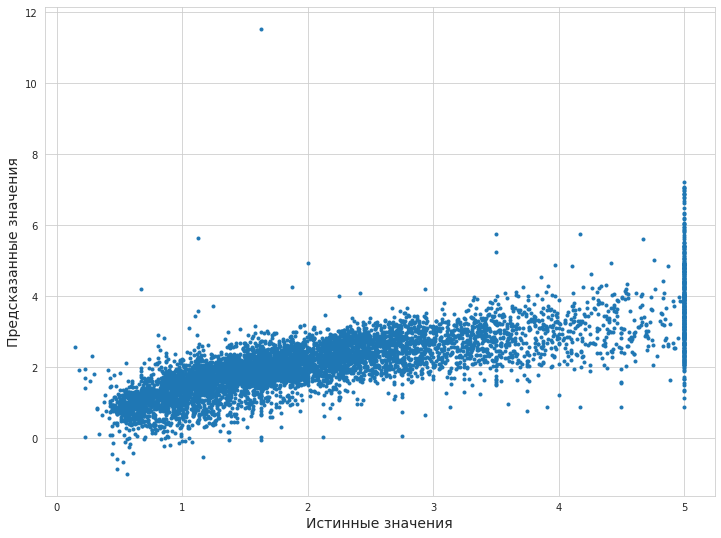

In [33]:
plt.scatter(y_test, y_test_pred, marker=".")
plt.xlabel("Истинные значения", fontsize=14)
plt.ylabel("Предсказанные значения", fontsize=14)
plt.show()

In [35]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    #import math
    return 1 / (1 + np.exp(-output))


In [36]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    res = -sum(y_true * np.log(sigmoid(y_pred))+ (1 - y_true) * np.log(1 - sigmoid(y_pred)))
    return res

In [37]:
def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return X.T.dot(sigmoid(y_pred) - y_true) 
    


In [38]:
class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

In [39]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return sigmoid(X_test@self.W)
    
    def __repr__(self):
        return "My custom logistic regression"

In [40]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

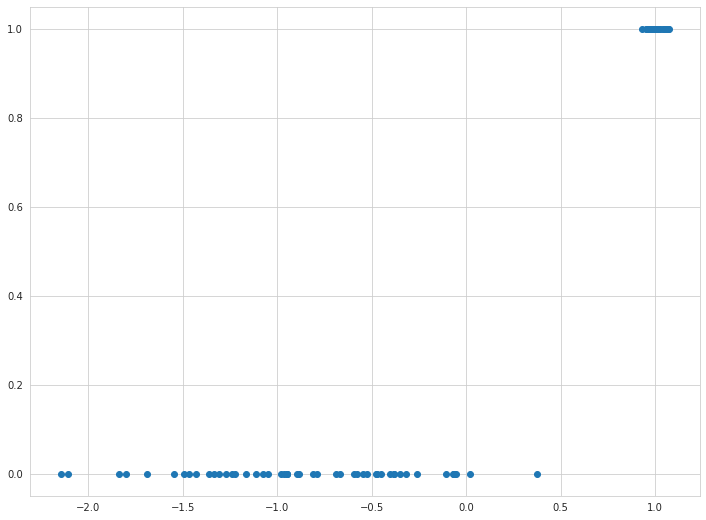

In [42]:
plt.scatter(X, y)

In [43]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

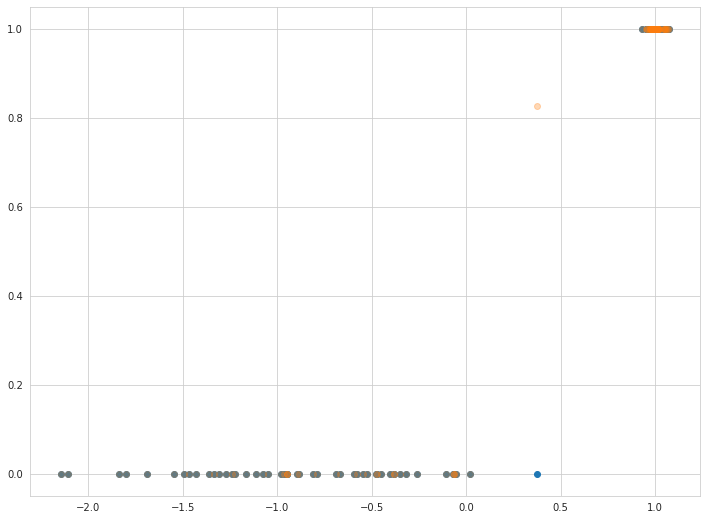

In [45]:
plt.scatter(X, y)
plt.scatter(X, y_pred, alpha = 0.3);

In [52]:
accuracy_score(y, y_pred>0.5)

0.99

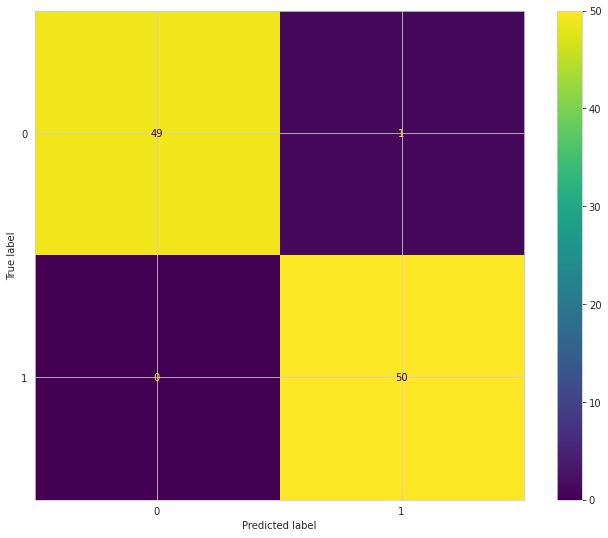

In [54]:
ConfusionMatrixDisplay.from_predictions(y, y_pred>0.5)

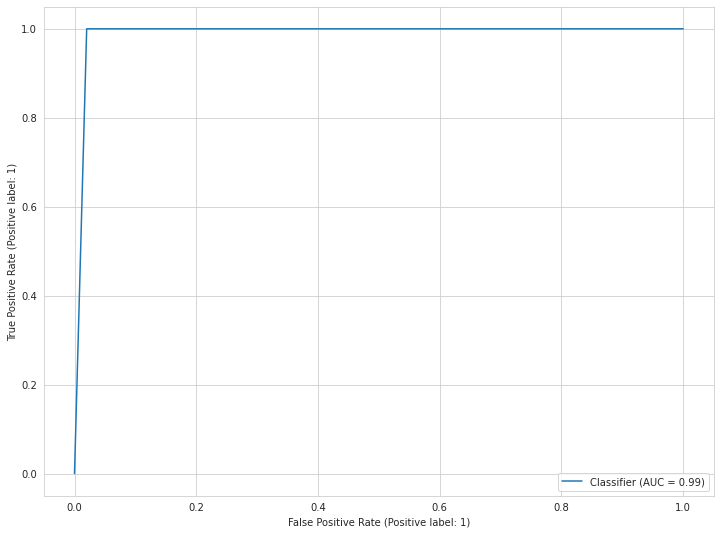

In [56]:
RocCurveDisplay.from_predictions(y, y_pred>0.5)

In [87]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [88]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [89]:
pokemon.isnull().sum().sum()

386

In [90]:
pokemon['Legendary'] = pokemon['Legendary'].astype('int')
pokemon = pokemon.drop(columns='Name') 
pokemon = pokemon.drop(columns='Type 2') 

In [112]:
pokemon = pokemon.drop(columns='#') 

In [127]:
pokemon = pokemon.drop(columns='Type 1') 

In [128]:
pokemon.head(100)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,318,45,49,49,65,65,45,1,0
1,405,60,62,63,80,80,60,1,0
2,525,80,82,83,100,100,80,1,0
3,625,80,100,123,122,120,80,1,0
4,309,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...
95,325,80,80,50,40,50,25,1,0
96,500,105,105,75,65,100,50,1,0
97,305,30,65,100,45,25,40,1,0
98,525,50,95,180,85,45,70,1,0


In [130]:
X = pokemon.values[::, 0:6]
y = pokemon["Legendary"]

In [133]:
X

array([[318,  45,  49,  49,  65,  65],
       [405,  60,  62,  63,  80,  80],
       [525,  80,  82,  83, 100, 100],
       ...,
       [600,  80, 110,  60, 150, 130],
       [680,  80, 160,  60, 170, 130],
       [600,  80, 110, 120, 130,  90]])

In [134]:
y

0      0
1      0
2      0
3      0
4      0
      ..
795    1
796    1
797    1
798    1
799    1
Name: Legendary, Length: 800, dtype: int64

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=777)

In [136]:
print(f"Train size = {y_train.shape}")
print(f"Test size = {y_test.shape}")

Train size = (560,)
Test size = (240,)


In [137]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [139]:
y_train_pred = logreg.predict(X_train)

In [140]:
y_test_pred = logreg.predict(X_test)
y_test_pred[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [141]:
y_test[:30]

197    0
170    0
224    0
517    0
496    0
387    0
737    0
168    0
507    0
323    0
457    0
702    1
48     0
431    1
69     0
434    0
347    0
278    0
143    0
146    0
476    0
75     0
219    0
648    0
176    0
394    0
43     0
39     0
310    0
126    0
Name: Legendary, dtype: int64

In [144]:
print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       512
           1       0.64      0.48      0.55        48

    accuracy                           0.93       560
   macro avg       0.80      0.73      0.76       560
weighted avg       0.93      0.93      0.93       560



In [153]:
roc_auc_score(y_true=y_train, y_score=y_train)

1.0

In [154]:
roc_auc_score(y_true=y_test, y_score=y_test)

1.0

In [155]:
y_train_proba = logreg.predict_proba(X_train)[:,1]
y_test_proba = logreg.predict_proba(X_test)[:,1]

In [158]:
fpr_train, tpr_train, thres_train = roc_curve(y_true=y_train, y_score=y_train_proba)
fpr_test, tpr_test, thres_test = roc_curve(y_true=y_test, y_score=y_test_proba)

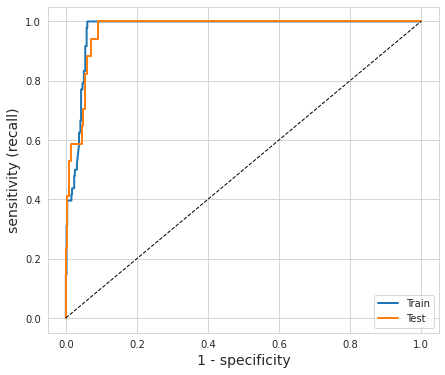

In [159]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, label="Train", lw=2)
plt.plot(fpr_test, tpr_test, label="Test", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.ylabel("sensitivity (recall)", fontsize=14)
plt.xlabel("1 - specificity", fontsize=14)
plt.legend(); plt.show()

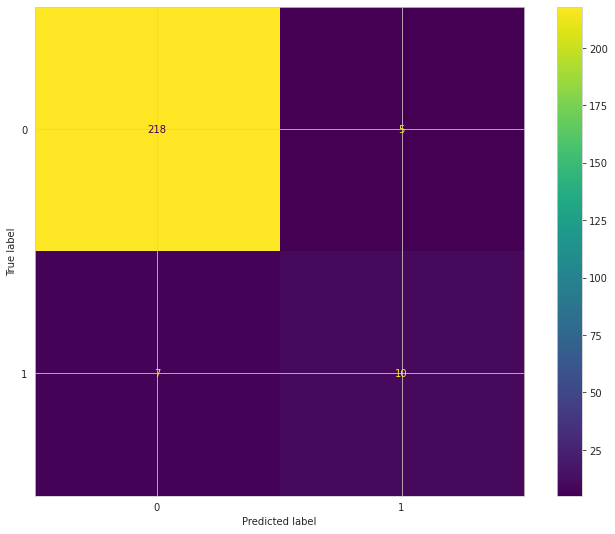

In [164]:
plot_confusion_matrix(estimator=logreg, X=X_test, y_true=y_test)